In [43]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [44]:

# Training Parameters# Train 
learning_rate = 0.001
num_steps = 2000
batch_size = 128

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.25 # Dropout, probability to drop a unit

In [45]:
# Create the neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        # Convolution Layer with 32 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 64 filters and a kernel size of 3
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out

In [46]:

# Define the model function (following TF Estimator Template)# Defin 
def model_fn(features, labels, mode):
    
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)
    
    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [47]:

# Build the Estimator# Build 
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp0_om_p1f', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe2276d0780>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [48]:
%load_ext autoreload
%autoreload 2
from __future__ import absolute_import

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import os
import sys
import pandas as pd
%matplotlib inline

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from all_apps import sweep_an
#stream_data = {}
combined_data_ = sweep_an.all_st()

In [50]:
#Going through metrics
import numbers
import glob
import os
import csv

#combined_data_ = {}

metric_targets = []
all_sig_metrics = []
bench_targets = [ "gaussian" ,"gemm", "stream" ]
for filen_ in glob.glob("/home/yzamora/power/nvidia_gpus/all_apps/all_results/*.csv"):
#for filen_ in glob.glob("/home/yzamora/power/nvidia_gpus/all_apps/gaussian_results/*.csv"):
    filen = os.path.basename(filen_)
    #print (filen)
    filen_split = filen.split('.')[0].split('_')
    bench_name = filen_split[0]
    #metric_name = filen_split[1]
    #print(filen_split)
    size_str = filen_split[1].split('N')[1]
    
    #if not (metric_name in metric_targets): continue
    if not (bench_name in bench_targets): continue
    
    key_root = bench_name+"_"+size_str
    #print(key_root)
    levels = ["Idle", "Low","High", "Max"]
    bw_units = ["GB", "MB", "KB" ,"0B"]
    # Now open the file and look for the data
    with open(filen_ ,'r') as file_handle:
        #print (file_handle)
        data_found = False
        ncols = 1
        fdata = csv.reader(file_handle)
        index_lookup = {}
        #print(filen_)
        for line_split in fdata:
            #print (line_split)
            lsplt = (len(line_split) > 0)
      
            if data_found:
                #print("data found")
                if lsplt and len(line_split) == ncols:
                    #percent - strip off end
                    # Get metric name here
                    #mname_index = index_lookup['Metric Name']
                    #metric_name = line_split[ mname_index ]
                    #if not (metric_name in metric_targets): continue
                    
                    # Read in desired value for the current metric
                    target_index = index_lookup['Avg']; value = 0
                    metric_name = line_split[index_lookup['Metric Name']]
                    #print (line_split[target_index].isdecimal())
                    if line_split[target_index].isdecimal():
                        if line_split[target_index]!= '0':
                            #print(line_split[target_index])
                            all_sig_metrics.append(metric_name)
                            value = int(line_split[ target_index ])
                        
                        # Labeled with percentage
                    elif "%" == line_split[target_index][-1]:
                        #print ("percentage loop")
                        all_sig_metrics.append(metric_name)
                        value = float(line_split[ target_index ][0:7]) / 100.0
                        
                    # Labeled with bandwidth units
                    elif line_split[ target_index ][-4:-2] in bw_units:
                        # Just take the first 
                        units = line_split[ target_index ][-4:-2]
                        all_sig_metrics.append(metric_name)
                        mfact = 1.0
                        if   units == "KB": mfact = 1024
                        elif units == "MB": mfact = 1024*1024
                        elif units == "GB": mfact = 1024*1024*1024
                        elif units == "0B":  mfact = 1
                        value = float(line_split[ target_index ][0:7]) * mfact
                    
                    # idle, low, max
                    elif line_split[ target_index ][-1] == ")":
                        #print ("low")
                        all_sig_metrics.append(metric_name)
                        value = int(line_split[ target_index].split('(')[1].split(")")[0])
                        
                    # otherwise, float
                    #elif not(float(line_split[ target_index ]).is_integer()):
                    else:
                        #print(line_split[ target_index ].split('(')[0])
                        #print("in float")
                        #print(line_split[ target_index ].split('(')[0])
                        value = float(line_split[ target_index ])
                    
                    
                    
                    # Parse name of kernel
                    kernel_name = line_split[ index_lookup['Kernel'] ].split('(')[0]
                    
                    # Define kernel-specific key
                    key = key_root + "_" + kernel_name
                    
                    # Initialize dict for this key, if it is new
                    if not (key in combined_data_): 
                        combined_data_ [ key ] = {}
                        combined_data_ [ key ][ 'size' ] = int( size_str )
                        
                    # Store value for the metric being read right now
                    combined_data_ [ key ][ metric_name ] = value
                    
                else: data_found = False


            elif lsplt and line_split[0] == 'Device' and line_split[1] == 'Kernel':
                # Set flag that we are at the data:
                data_found = True
                # Set number of columns in table:
                ncols = len(line_split)
                # Generate an index lookup table:
                idx = 0
                for term in line_split:
                    index_lookup[term] = idx
                    idx += 1
                #print(index_lookup)

In [51]:
executable = "gaussian"
for file in glob.glob("/home/yzamora/power/nvidia_gpus/all_apps/gaussian_time_timing/*.csv"):
    #nf = "gaussian_N128.csv"
    nf = os.path.basename(file)
    filesplt = os.path.basename(nf).split(".")[0].split('N')[1]
    filename = executable + "_" + filesplt
    #print(filename)
    for key, value in combined_data_.items():
        #print(key)
        if filename in key:
            with open(file) as results:
                for l in results:
                    if "Time for CUDA kernel 1" in l:
                        #print("in kern")
                        combined_data_[key]["Time(s)"] = float(l.split(":")[1].split()[0])

In [52]:
#gemm_N128.csv
executable = "gemm_"
for file in glob.glob("/home/yzamora/power/nvidia_gpus/all_apps/gemm_timing/*.csv"):
    #print (file)
    filesplt = os.path.basename(file).split(".")[0].split('N')[1]
    filen = executable + filesplt +"_sge"
    #print(filen)
    for key, value in combined_data_.items():      
        if filen in key:
            with open(file) as results:
                for l in results:
                    if "average" in l:
                        combined_data_[key]["Time(s)"] = float(l.split(":")[2].split()[0])

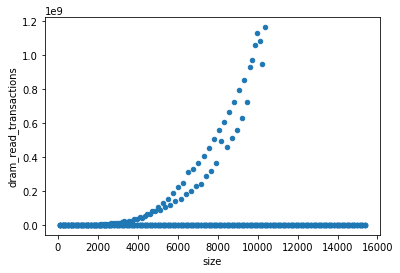

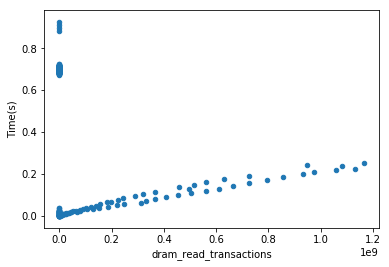

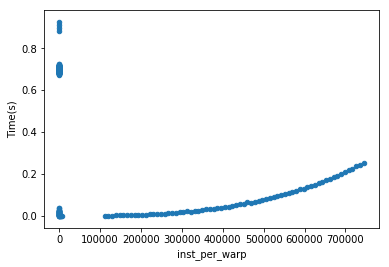

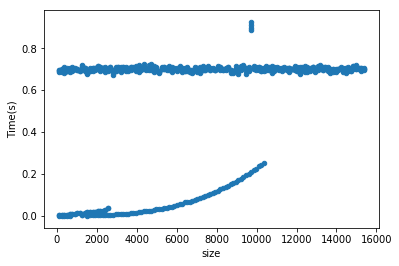

In [53]:
#Simple analysis of data
import pandas as pd
%matplotlib inline
#stream_data
df = pd.DataFrame.from_dict(combined_data_,orient="index")
#df = pd.DataFrame.from_dict(stream_data,orient="index")

df = df.dropna()
#print(df['Time(s)'])

#print (df.head())

df.plot(x='size', y='dram_read_transactions', kind='scatter')
df.plot(x='dram_read_transactions', y='Time(s)', kind='scatter')
df.plot(x='inst_per_warp', y='Time(s)', kind='scatter')
df.plot(x='size', y='Time(s)', kind='scatter')

In [111]:
import pandas as pd
%matplotlib inline


df = pd.DataFrame.from_dict(combined_data_,orient="index")
display(df.head())

,size,inst_per_warp,branch_efficiency,warp_execution_efficiency,warp_nonpred_execution_efficiency,inst_replay_overhead,shared_load_transactions_per_request,shared_store_transactions_per_request,local_load_transactions_per_request,local_store_transactions_per_request,...,special_fu_utilization,half_precision_fu_utilization,single_precision_fu_utilization,double_precision_fu_utilization,flop_hp_efficiency,flop_sp_efficiency,flop_dp_efficiency,sysmem_read_utilization,sysmem_write_utilization,Time(s)
gaussian_1024_Fan1,1024,33.151515,0.999903,0.977705,0.950647,0.148065,0.0,0.0,0.0,0.0,...,1,0,1,0,0.0,0.000137,0.0,0,1,0.010958
gaussian_1024_Fan2,1024,27.771998,1.000000,0.498486,0.485504,0.001007,0.0,0.0,0.0,0.0,...,0,0,1,0,0.0,0.000602,0.0,0,1,0.010958
gaussian_1152_Fan1,1152,27.809948,0.999916,0.982889,0.958649,0.168038,0.0,0.0,0.0,0.0,...,1,0,1,0,0.0,0.000153,0.0,0,1,0.012782
gaussian_1152_Fan2,1152,27.760276,1.000000,0.498654,0.485668,0.000818,0.0,0.0,0.0,0.0,...,0,0,1,0,0.0,0.000598,0.0,0,1,0.012782
gaussian_1280_Fan1,1280,29.516158,0.999929,0.983698,0.958356,0.160663,0.0,0.0,0.0,0.0,...,1,0,1,0,0.0,0.000174,0.0,0,1,0.001306


In [241]:
df = df.dropna()
X  =  df[['inst_per_warp','size','branch_efficiency','warp_execution_efficiency','warp_nonpred_execution_efficiency']]
y = df['Time(s)']

#print (df)
print ("X size:", X.shape)
print ('y size:', y.shape)
k = X.values
s = y.values
m,n=df.shape

X size: (595, 5)
y size: (595,)


In [242]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
# Define the input function for training
import numpy as np

#X = X.values
#y = y.values

X_train, X_test, y_train, y_test = train_test_split(X,y)

print("y_train",y_train.shape)
print("X_train",X_train.shape)
print("X_test",X_test.shape)
print("y_train", y_train.shape)
print("y_test",y_test.shape)
xt = y_train.values
yt = y_train.values
x = tf.placeholder(tf.float32, name="X")
y_ = tf.placeholder(tf.float32, name="y")
batch_size = 200
n_batchs=int(np.ceil(m/batch_size))
    

y_train (446,)
X_train (446, 5)
X_test (149, 5)
y_train (446,)
y_test (149,)


In [249]:
# Generate predetermined random weights so the networks are similarly initialized
w1_initial = np.random.normal(size=(595,100)).astype(np.float32)
w2_initial = np.random.normal(size=(100,100)).astype(np.float32)
w3_initial = np.random.normal(size=(100,10)).astype(np.float32)

# Small epsilon value for the BN transform
epsilon = 1e-3

In [250]:
# Placeholders
x = tf.placeholder(tf.float32, shape=[None, 595])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [251]:

# Layer 2 without BN
w2 = tf.Variable(w2_initial)
b2 = tf.Variable(tf.zeros([100]))
z2 = tf.matmul(l1,w2)+b2
l2 = tf.nn.sigmoid(z2)

In [252]:
# Layer 1 with BN
w1_BN = tf.Variable(w1_initial)

# Note that pre-batch normalization bias is ommitted. The effect of this bias would be
# eliminated when subtracting the batch mean. Instead, the role of the bias is performed
# by the new beta variable. See Section 3.2 of the BN2015 paper.
z1_BN = tf.matmul(x,w1_BN)

# Calculate batch mean and variance
batch_mean1, batch_var1 = tf.nn.moments(z1_BN,[0])

# Apply the initial batch normalizing transform
z1_hat = (z1_BN - batch_mean1) / tf.sqrt(batch_var1 + epsilon)

# Create two new parameters, scale and beta (shift)
scale1 = tf.Variable(tf.ones([100]))
beta1 = tf.Variable(tf.zeros([100]))

# Scale and shift to obtain the final output of the batch normalization
# this value is fed into the activation function (here a sigmoid)
BN1 = scale1 * z1_hat + beta1
l1_BN = tf.nn.sigmoid(BN1)

In [255]:
# Layer 2 with BN, using Tensorflows built-in BN function
w2_BN = tf.Variable(w2_initial)
z2_BN = tf.matmul(l1_BN,w2_BN)
batch_mean2, batch_var2 = tf.nn.moments(z2_BN,[0])
scale2 = tf.Variable(tf.ones([100]))
beta2 = tf.Variable(tf.zeros([100]))
BN2 = tf.nn.batch_normalization(z2_BN,batch_mean2,batch_var2,beta2,scale2,epsilon)
l2_BN = tf.nn.sigmoid(BN2)

In [256]:
# Softmax
w3 = tf.Variable(w3_initial)
b3 = tf.Variable(tf.zeros([10]))
y  = tf.nn.softmax(tf.matmul(l2,w3)+b3)

w3_BN = tf.Variable(w3_initial)
b3_BN = tf.Variable(tf.zeros([10]))
y_BN  = tf.nn.softmax(tf.matmul(l2_BN,w3_BN)+b3_BN)

In [257]:
# Loss, optimizer and predictions
cross_entropy = -tf.reduce_sum(y_*tf.log(y))
cross_entropy_BN = -tf.reduce_sum(y_*tf.log(y_BN))

train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
train_step_BN = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy_BN)

correct_prediction = tf.equal(tf.arg_max(y,1),tf.arg_max(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
correct_prediction_BN = tf.equal(tf.arg_max(y_BN,1),tf.arg_max(y_,1))
accuracy_BN = tf.reduce_mean(tf.cast(correct_prediction_BN,tf.float32))

Instructions for updating:
Use `argmax` instead


In [266]:
df = df.dropna()
X  =  df[['inst_per_warp','size','branch_efficiency','warp_execution_efficiency','warp_nonpred_execution_efficiency']]
y = df['Time(s)']
X_train, X_test, y_train, y_test = train_test_split(X,y)
print (X_train.keys())

Index(['inst_per_warp', 'size', 'branch_efficiency',
       'warp_execution_efficiency', 'warp_nonpred_execution_efficiency'],
      dtype='object')


In [267]:
zs, BNs, acc, acc_BN = [], [], [], []
X_train, X_test, y_train, y_test = train_test_split(X,y)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for i in tqdm.tqdm(range(40000)):
    batch = X_train
    train_step.run(feed_dict={x: X_train, y_: y_test})
    train_step_BN.run(feed_dict={x:  X_train, y_: y_test})
    if i % 50 is 0:
        res = sess.run([accuracy,accuracy_BN,z2,BN2],feed_dict={x: X_train.values(), y_: X_train.keys()})
        acc.append(res[0])
        acc_BN.append(res[1])
        zs.append(np.mean(res[2],axis=0)) # record the mean value of z2 over the entire test set
        BNs.append(np.mean(res[3],axis=0)) # record the mean value of BN2 over the entire test set

zs, BNs, acc, acc_BN = np.array(zs), np.array(BNs), np.array(acc), np.array(acc_BN)

InvalidArgumentError: You must feed a value for placeholder tensor 'X_15' with dtype double and shape [595,5]
	 [[Node: X_15 = Placeholder[dtype=DT_DOUBLE, shape=[595,5], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'X_15', defined at:
  File "/home/yzamora/miniconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/yzamora/miniconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/yzamora/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/yzamora/miniconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/yzamora/miniconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/yzamora/miniconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/yzamora/miniconda3/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/yzamora/miniconda3/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/yzamora/miniconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/yzamora/miniconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/home/yzamora/miniconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/yzamora/miniconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/yzamora/miniconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/yzamora/miniconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/yzamora/miniconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/yzamora/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/yzamora/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/yzamora/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/yzamora/miniconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/yzamora/miniconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/yzamora/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/yzamora/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/yzamora/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/yzamora/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-194-8fd2943ea77b>", line 18, in <module>
    x = tf.placeholder(tf.float64, shape=[595,5], name="X")
  File "/home/yzamora/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1735, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/yzamora/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 4925, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/home/yzamora/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/yzamora/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/home/yzamora/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/home/yzamora/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'X_15' with dtype double and shape [595,5]
	 [[Node: X_15 = Placeholder[dtype=DT_DOUBLE, shape=[595,5], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
